# Logistic Clasification
![](https://sci2lab.github.io/ml_tutorial/images/linear_regression_not_working.svg)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import torch
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("ex/features.csv")
data.head()

,sex,amp,peak,n170,de
0,f,3.976976,1.396650,3.518662,-4.641687
1,f,2.838296,-2.903568,-1.997229,-4.701930
2,f,-1.428451,-2.606083,0.109957,-4.652843
3,f,-3.363337,3.906902,7.463065,-4.681531
4,f,0.229698,0.727408,2.955038,-4.733215


<AxesSubplot:xlabel='n170', ylabel='de'>

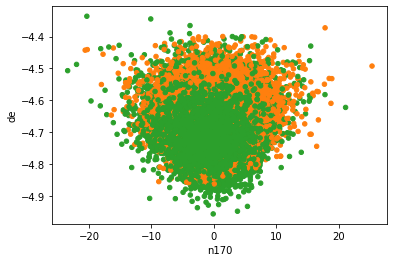

In [3]:
data["color"] = (data["sex"] == "f").apply(lambda x: "C1" if x else "C2")
data.plot.scatter("n170", "de", c="color")

The features don't seem to be linearly separable, so a high accuracy is not expected.

This scikit-learn model expects a features matrix and a labels vector.

In [4]:
X = data[["amp", "peak", "n170", "de"]]
Y = data[["sex"]] == "f"
print(X.shape, Y.shape)

(21604, 4) (21604, 1)


A 70/30 split is done for testing and training purposes. This evaluates the model's generalizability.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

## The model

In [6]:
from torch.autograd import Variable
class LogisticRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out

In [7]:
inputDim = X.shape[1]        # takes variable 'x' 
outputDim = Y.shape[1]       # takes variable 'y'
learningRate = 0.1 
epochs = 50

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [9]:
model = LogisticRegression(inputDim, outputDim)
model.to(device)

LogisticRegression(
  (linear): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [10]:
criterion = torch.nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [11]:
ltr_curve = []
atr_curve  = []
lts_curve = []
ats_curve  = []
for epoch in range(epochs):
    # Train Set
    inputs = Variable(torch.tensor(X_train.values.astype(np.float32))).to(device)
    labels = Variable(torch.tensor(y_train.values.astype(np.float32))).to(device)

    optimizer.zero_grad()
    y_hat = model(inputs)

    loss = criterion(y_hat, labels)
    train_loss = loss.item()
    ltr_curve.append(train_loss)
    
    train_acc = torch.sum(y_hat.round() == labels) / labels.size(0)
    atr_curve.append(train_acc.cpu().detach().numpy())
    
    # Optimization
    loss.backward()
    optimizer.step()
    
    # Test set    
    y_hat = model(Variable(torch.tensor(X_test.values.astype(np.float32))).to(device))
    test_lbls = Variable(torch.tensor(y_test.values.astype(np.float32))).to(device)
    test_loss = criterion(y_hat, test_lbls)
    test_loss = test_loss.item()
    lts_curve.append(test_loss)
    test_acc = torch.sum(y_hat.round() == test_lbls) / test_lbls.size(0)
    ats_curve.append(test_acc.cpu().detach().numpy())


    print('epoch {}, loss {}, test accuracy {}'.format(epoch, loss.item(), test_acc))

epoch 0, loss 1.3117860555648804, test accuracy 0.538722574710846
epoch 1, loss 1.0388158559799194, test accuracy 0.5303918123245239
epoch 2, loss 0.8764813542366028, test accuracy 0.5217525362968445
epoch 3, loss 0.7899937629699707, test accuracy 0.5209811329841614
epoch 4, loss 0.743151843547821, test accuracy 0.5217525362968445
epoch 5, loss 0.7184563875198364, test accuracy 0.5209811329841614
epoch 6, loss 0.7059839963912964, test accuracy 0.5205183625221252
epoch 7, loss 0.6996690630912781, test accuracy 0.5240666270256042
epoch 8, loss 0.696292519569397, test accuracy 0.5239123702049255
epoch 9, loss 0.6942877769470215, test accuracy 0.524220883846283
epoch 10, loss 0.6929309368133545, test accuracy 0.529003381729126
epoch 11, loss 0.6918969750404358, test accuracy 0.5336315631866455
epoch 12, loss 0.6910409927368164, test accuracy 0.5354828834533691
epoch 13, loss 0.6902977228164673, test accuracy 0.5381054878234863
epoch 14, loss 0.6896359324455261, test accuracy 0.537951231002

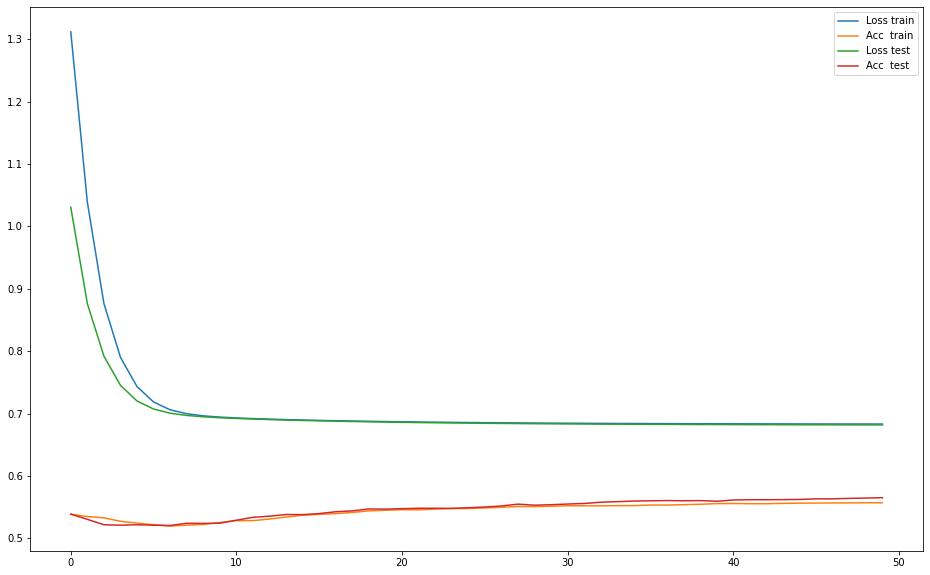

In [12]:
fig = plt.figure(figsize=(16,10))
plt.plot(ltr_curve, label="Loss train")
plt.plot(atr_curve, label="Acc  train")
plt.plot(lts_curve, label="Loss test")
plt.plot(ats_curve, label="Acc  test")
plt.legend()
plt.show()

In [13]:
coef = [p.cpu().detach().numpy() for p in model.parameters()]

Compare to LDA and LogisticRegression

In [14]:
lda = LDA()
lda.fit(X_train, y_train)
print(lda.score(X_train, y_train))
print(lda.score(X_test, y_test))

0.5978045232112155
0.5978093181116939


/opt/conda/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [15]:
logreg = LogisticRegression(random_state=0).fit(X_train, y_train)
print(logreg.score(X_train, y_train))
print(logreg.score(X_test, y_test))

TypeError: __init__() got an unexpected keyword argument 'random_state'

In [ ]:
print(coef[0])
print(lda.coef_)
print(logreg.coef_)

# Visualization

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train.to_numpy())
fig = plt.figure(figsize=(16,10))
cmap = plt.cm.get_cmap('tab10')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap(y_train.to_numpy().astype(int)))

In [ ]:
X_tr = (X_train.to_numpy() + coef[1]) * coef[0]
print(X_tr)

In [ ]:
Y_tr = y_train.to_numpy().astype(int)
print(Y_tr)

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_tr)
print(X_embedded.shape)

In [ ]:
fig = plt.figure(figsize=(16,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap(Y_tr))

In [ ]:
X_tr = (X_train.to_numpy() + linreg.coef_)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_tr)
print(X_embedded.shape)
fig = plt.figure(figsize=(16,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap(Y_tr))

In [ ]:
X_tr = (X_train.to_numpy() + lda.coef_)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_tr)
print(X_embedded.shape)
fig = plt.figure(figsize=(16,10))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap(Y_tr))